In [737]:
from constants import price_models
from standard_pricing_model import get_standard_cost
from timing_pricing_model import get_timing_price_model_cost
from utils import (
    load_data,
    get_tier
)
import pandas as pd
import matplotlib.pyplot as plt

In [738]:
def get_pricing_category(time, price_model):
    if not 'time_ranges' in price_model:
        return 'default'

    for category, time_ranges in price_model['time_ranges'].items():

        for range in time_ranges:
            start, end = range

            if time.hour >= start and time.hour < end:
                return category

In [739]:
def get_rate(row, price_model):
    return price_model['rate'][row['tier']][row['rate_category']]

In [740]:
def get_month_cost(month_group, price_model):
    month_group['cumulative_kwh'] = month_group['Consumption'].cumsum()
    month_group['tier'] = month_group['cumulative_kwh'].apply(get_tier)
    month_group['pricing_category'] = month_group['Start Time'].apply(lambda x: get_pricing_category(x, price_model))
    month_group['rate'] = month_group.apply(lambda row: get_rate(row, price_model), axis=1)
    month_group['daily_cost'] = month_group['rate'] * month_group['Consumption']


    return month_group['daily_cost'].sum()


In [741]:
from nis import cat


def main():
    df = pd.read_csv('data.csv', skiprows=13, parse_dates=['Date', 'Start Time'])

    
    df['monthly_consumption'] = df['Consumption'].groupby(df.Date.dt.month).cumsum()
    df['tier'] = df['monthly_consumption'].apply(get_tier)
    
    price_model_names = []

    for price_model in price_models:
      price_model_name = price_model['name']

      price_model_names.append(price_model_name)

      df['rate_category'] = df.apply(lambda row: 
        get_pricing_category(row['Start Time'], price_model), 
        axis=1)

      df['rate'] = df.apply(lambda row:
        price_model['rate'][row['tier']][row['rate_category']],
        axis=1)

      df[f'{price_model_name}_daily_cost'] = df['Consumption'] * df['rate']
      df[f'{price_model_name}_mean_cost'] = df['Consumption'] * df['rate']

    
    fig, axs = plt.subplots()

    category_names = [f'{name}_daily_cost' for name in price_model_names]

    axs = df[['Date', *category_names]].groupby(df.Date.dt.month).sum().plot(kind='bar', linewidth=1, figsize=(8,5), width=.75, ax=axs)

    axs.set_ylabel('Cost $')
    axs.set_xlabel('Month')
    plt.legend([*price_model_names], title='Pricing Models')
    plt.title('Monthly Cost Comparison')

    # itd be cool to get average kwh per price model
      


  

      2021  2022  Consumption  standard_daily_cost  tou_dr1_daily_cost  \
Date                                                                     
2021   NaN   NaN          NaN                  NaN                 NaN   
2022   NaN   NaN          NaN                  NaN                 NaN   

      tou_dr2_daily_cost  
Date                      
2021                 NaN  
2022                 NaN  


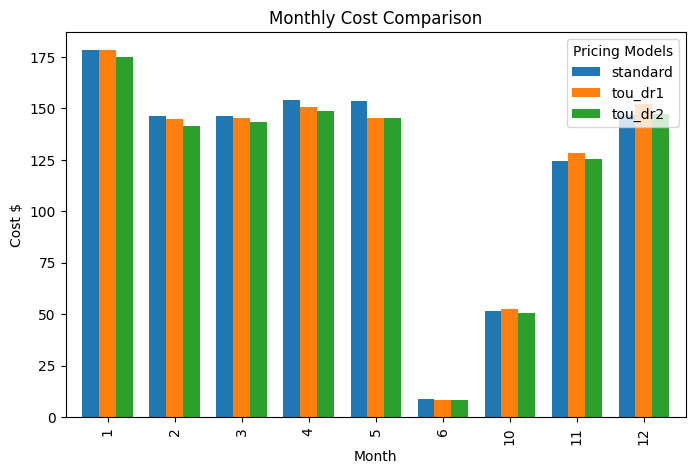

In [742]:
main()